## First Level Analysis

In [1]:
from nilearn import plotting
%matplotlib inline
import os
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
from nipype.interfaces import spm
from nipype.interfaces import fsl
from nipype.interfaces import matlab as mlab

In [2]:
spm.SPMCommand.set_mlab_paths(paths=os.path.abspath('./Documents/MATLAB/spm12/'), matlab_cmd='/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash')

stty: 'standard input': Inappropriate ioctl for device


In [3]:
mlab.MatlabCommand.set_default_matlab_cmd("/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB  -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(os.path.abspath('./Documents/MATLAB/spm12/'))

In [4]:
spm.SPMCommand.set_mlab_paths(paths='/home/matay/Documents/MATLAB/spm12/', matlab_cmd='/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash')

stty: 'standard input': Inappropriate ioctl for device


In [5]:
mlab.MatlabCommand.set_default_matlab_cmd("/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB  -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths('/home/matay/Documents/MATLAB/spm12/')

In [6]:
# spm.SPMCommand().version

In [7]:
fsl.FSLCommand.set_default_output_type('NIFTI')

In [8]:
base_dir = os.path.join(os.environ['HOME'], 'spmbasics/data/')

In [9]:
data_dir = os.path.join(base_dir, 'MoAEpilot/task-auditory_bold.json')

In [10]:
experiment_dir = os.path.join(base_dir, 'output')
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['01']
task_id = ['auditory']

# TR of functional images
with open(os.path.join(base_dir, 'MoAEpilot/task-auditory_bold.json'), 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing width used during preprocessing
fwhm = [6]

In [11]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='scans',
                                 output_units='scans',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix same as the first level tutorial
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='scans',
                                 interscan_interval=TR,
                                 volterra_expansion_order=1,
                                 flags={'mthresh': 0.8},
                                 global_intensity_normalization='none',
                                 microtime_onset=8,
                                 microtime_resolution=16,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      write_residuals=False, 
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

In [12]:
# Condition names
condition_names = ['listening']
#onsets = [6,18, 30, 42, 54, 66, 78]
# Contrasts
#onsets = ['listening',      'T', condition_names, [6, 18, 30, 42, 54, 66, 78]
cont01 = ['listening > rest','T', condition_names, [1, 0]]

contrast_list = [cont01]

In [13]:
# !cat ./spmbasics/data/MoAEpilot/sub-01/func/sub-01_task-auditory_events.tsv

In [14]:
# import pandas as pd
# trialinfo = pd.read_table(os.path.join(base_dir, 'MoAEpilot/sub-01/func/sub-01_task-auditory_events.tsv'))
# trialinfo

In [15]:
# for group in trialinfo.groupby('trial_type'):
#    print(group)
#    print("")

In [16]:
def subjectinfo(subject_id):

    import pandas as pd
    import os
    from nipype.interfaces.base import Bunch
    base_dir = os.path.join(os.environ['HOME'], 'spmbasics/data/')
    trialinfo = pd.read_table(os.path.join(base_dir, 'MoAEpilot/sub-01/func/sub-01_task-auditory_events.tsv'))
    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - 10)) # subtracting 10s due to removing of 4 dummy scans
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations,
                          #amplitudes=None,
                          tmod=None,
                          pmod=None,
                          #regressor_names=None,
                          #regressors=None
                         )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [17]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': os.path.join(working_dir, 'block_preproc_art', '_subject_id_{subject_id}_task_name_{task_id}',
                         'sub-{subject_id}_task-{task_id}_bold.nii'),
             'rptxt': os.path.join(working_dir, 'block_preproc_art', '_subject_id_{subject_id}_task_name_{task_id}', 'realign/'
                             'rp_sub-{subject_id}_task-{task_id}_bold.txt'),
             'outliers': os.path.join(working_dir, 'block_preproc_art', '_subject_id_{subject_id}_task_name_{task_id}', 'art/',
                             'art.warsub-{subject_id}_task-{task_id}_bold_outliers.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'auditory'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [18]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis_out')
l1analysis.base_dir = os.path.join(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('rptxt', 'realignment_parameters'),
                                             ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                  'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
    
                    ])

240515-18:39:23,587 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/l1analysis_out/colored_l1analysis.png (graph2use=colored, simple_form=True).


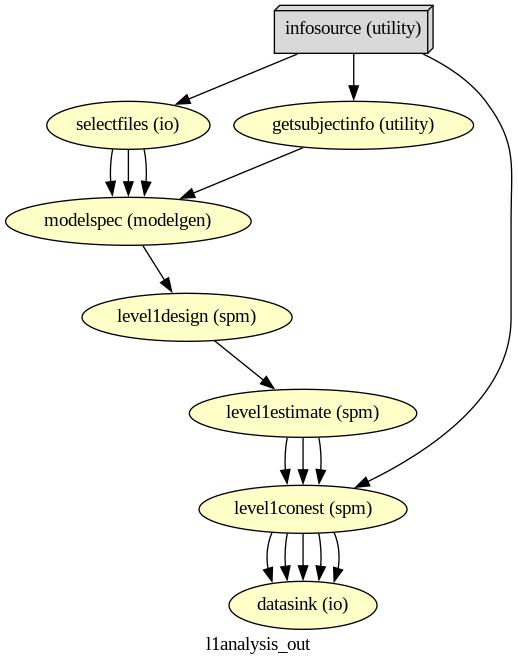

In [19]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', dotfilename='colored_l1analysis.dot', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(l1analysis.base_dir, 'l1analysis_out', 'colored_l1analysis.png'))

In [20]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

240515-18:39:29,530 nipype.workflow INFO:
	 Workflow l1analysis_out settings: ['check', 'execution', 'logging', 'monitoring']
240515-18:39:29,534 nipype.workflow INFO:
	 Running in parallel.
240515-18:39:29,535 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240515-18:39:29,592 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis_out.selectfiles" in "/home/matay/spmbasics/data/output/workingdir/l1analysis_out/_subject_id_01/selectfiles".
240515-18:39:29,592 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis_out.getsubjectinfo" in "/home/matay/spmbasics/data/output/workingdir/l1analysis_out/_subject_id_01/getsubjectinfo".
240515-18:39:29,595 nipype.workflow INFO:
	 [Node] Executing "getsubjectinfo" <nipype.interfaces.utility.wrappers.Function>
240515-18:39:29,595 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240515-18:39:29,598 nipype.workflow INFO:
	 [Node] Finish

/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: input contained no data: "/home/matay/spmbasics/data/output/workingdir/l1analysis_out/_subject_id_01/modelspec/art.warsub-01_task-auditory_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


240515-18:39:31,642 nipype.workflow INFO:
	 [Node] Finished "modelspec", elapsed time 0.008223s.
240515-18:39:33,541 nipype.workflow INFO:
	 [Job 2] Completed (l1analysis_out.modelspec).
240515-18:39:33,546 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240515-18:39:33,614 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis_out.level1design" in "/home/matay/spmbasics/data/output/workingdir/l1analysis_out/_subject_id_01/level1design".
240515-18:39:33,623 nipype.workflow INFO:
	 [Node] Executing "level1design" <nipype.interfaces.spm.model.Level1Design>
240515-18:39:35,542 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.57/13.77, Free processors: 3/4.
                     Currently running:
                       * l1analysis_out.level1design


stty: 'standard input': Inappropriate ioctl for device


240515-18:39:49,954 nipype.workflow INFO:
	 [Node] Finished "level1design", elapsed time 9.931439s.


stty: 'standard input': Inappropriate ioctl for device


240515-18:39:51,558 nipype.workflow INFO:
	 [Job 3] Completed (l1analysis_out.level1design).
240515-18:39:51,561 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240515-18:39:51,624 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis_out.level1estimate" in "/home/matay/spmbasics/data/output/workingdir/l1analysis_out/_subject_id_01/level1estimate".
240515-18:39:51,628 nipype.workflow INFO:
	 [Node] Executing "level1estimate" <nipype.interfaces.spm.model.EstimateModel>
240515-18:39:53,560 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.57/13.77, Free processors: 3/4.
                     Currently running:
                       * l1analysis_out.level1estimate


stty: 'standard input': Inappropriate ioctl for device


240515-18:40:12,978 nipype.workflow INFO:
	 [Node] Finished "level1estimate", elapsed time 14.935402s.


stty: 'standard input': Inappropriate ioctl for device


240515-18:40:13,581 nipype.workflow INFO:
	 [Job 4] Completed (l1analysis_out.level1estimate).
240515-18:40:13,585 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240515-18:40:13,626 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis_out.level1conest" in "/home/matay/spmbasics/data/output/workingdir/l1analysis_out/_subject_id_01/level1conest".
240515-18:40:13,631 nipype.workflow INFO:
	 [Node] Executing "level1conest" <nipype.interfaces.spm.model.EstimateContrast>
240515-18:40:15,584 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.57/13.77, Free processors: 3/4.
                     Currently running:
                       * l1analysis_out.level1conest


stty: 'standard input': Inappropriate ioctl for device


240515-18:40:30,74 nipype.workflow INFO:
	 [Node] Finished "level1conest", elapsed time 9.662996s.


stty: 'standard input': Inappropriate ioctl for device


240515-18:40:31,599 nipype.workflow INFO:
	 [Job 5] Completed (l1analysis_out.level1conest).
240515-18:40:31,602 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240515-18:40:31,666 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis_out.datasink" in "/home/matay/spmbasics/data/output/workingdir/l1analysis_out/_subject_id_01/datasink".
240515-18:40:31,670 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>
240515-18:40:31,685 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.014085s.
240515-18:40:33,601 nipype.workflow INFO:
	 [Job 6] Completed (l1analysis_out.datasink).
240515-18:40:33,605 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.


In [21]:
!tree /home/matay/spmbasics/data/output/datasink/1stLevel_out

/home/matay/spmbasics/data/output/datasink/1stLevel_out  [error opening dir]

0 directories, 0 files


In [22]:
from nilearn.plotting import plot_stat_map
anatimg = '/home/matay/spmbasics/data/MoAEpilot/sub-01/anat/sub-01_T1w.nii'

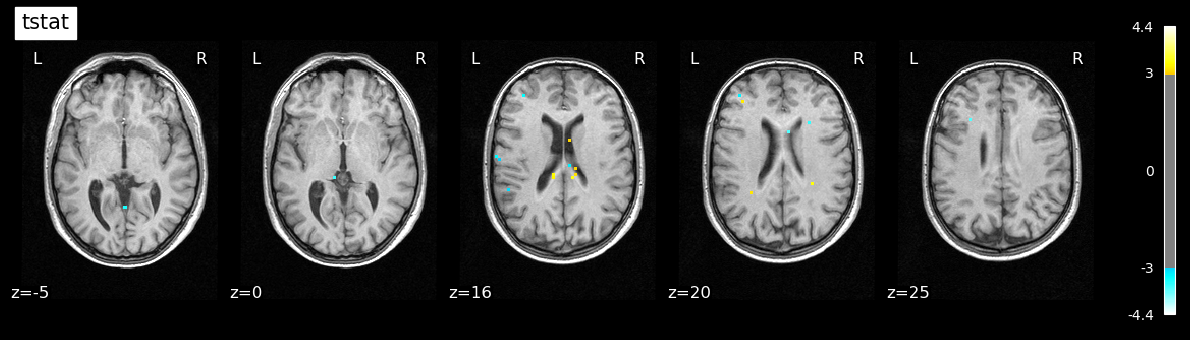

In [33]:
plot_stat_map(
    '/home/matay/spmbasics/data/output/datasink/1stLevel/_subject_id_01/spmT_0001.nii', title='tstat',
    bg_img=anatimg, threshold=3, display_mode='z', cut_coords=(-5, 0, 16, 20, 25), dim=-1);

/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:1317: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


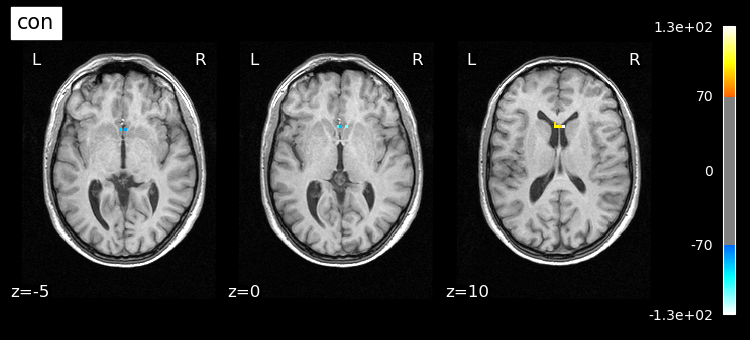

In [43]:
plot_stat_map(
    '/home/matay/spmbasics/data/output/datasink/1stLevel/_subject_id_01/con_0001.nii', title='con',
    bg_img=anatimg, threshold=70, display_mode='z', cut_coords=(-5, 0, 10), dim=-1);

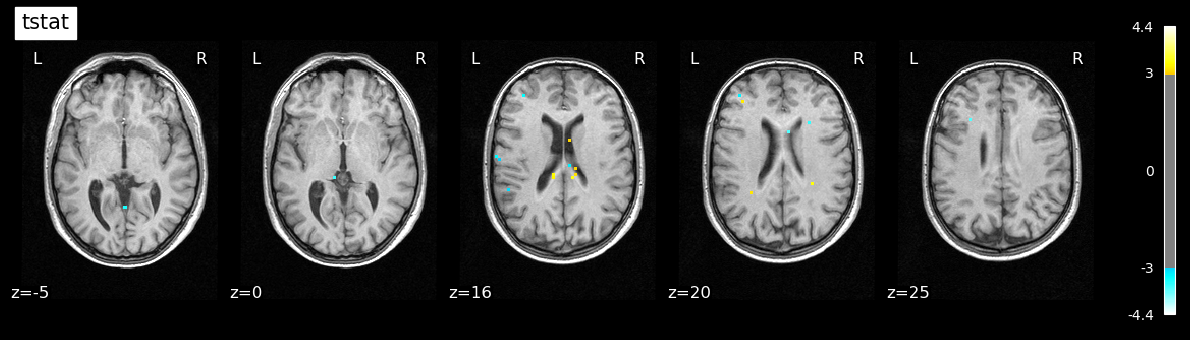

In [27]:
plot_stat_map(
    '/home/matay/spmbasics/data/output/workingdir/l1analysis_out/_subject_id_01/level1conest/spmT_0001.nii', title='tstat',
    bg_img=anatimg, threshold=3, display_mode='z', cut_coords=(-5, 0, 16, 20, 25), dim=-1);

/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:1317: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


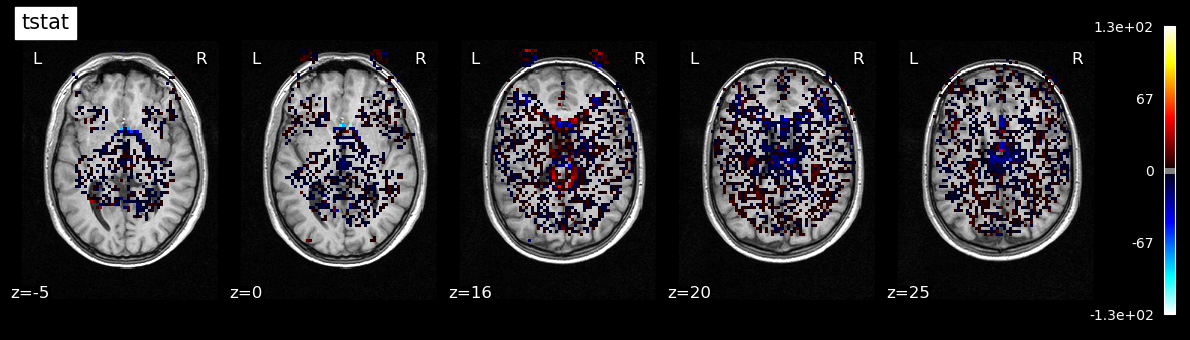

In [37]:
plot_stat_map(
    '/home/matay/spmbasics/data/output/workingdir/l1analysis_out/_subject_id_01/level1conest/con_0001.nii', title='tstat',
    bg_img=anatimg, threshold=3, display_mode='z', cut_coords=(-5, 0, 16, 20, 25), dim=-1);